In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '../scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]).scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '../scenes/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': '../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    }
})

In [4]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

In [7]:
opt = mi.ad.Adam(lr=0.025)
opt['angle'] = mi.Float(0.25)
opt['trans'] = mi.Point2f(0.1, -0.25)

In [8]:
def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    opt['angle'] = dr.clamp(opt['angle'], -0.5, 0.5)

    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0]).rotate([0, 1, 0], opt['angle'] * 100.0)

    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

In [9]:
apply_transformation(params, opt)

img_init = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [10]:
iteration_count = 50
spp = 16

In [11]:
loss_hist = []
for it in range(iteration_count):
    # Apply the mesh transformation
    apply_transformation(params, opt)

    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]", end='\r')

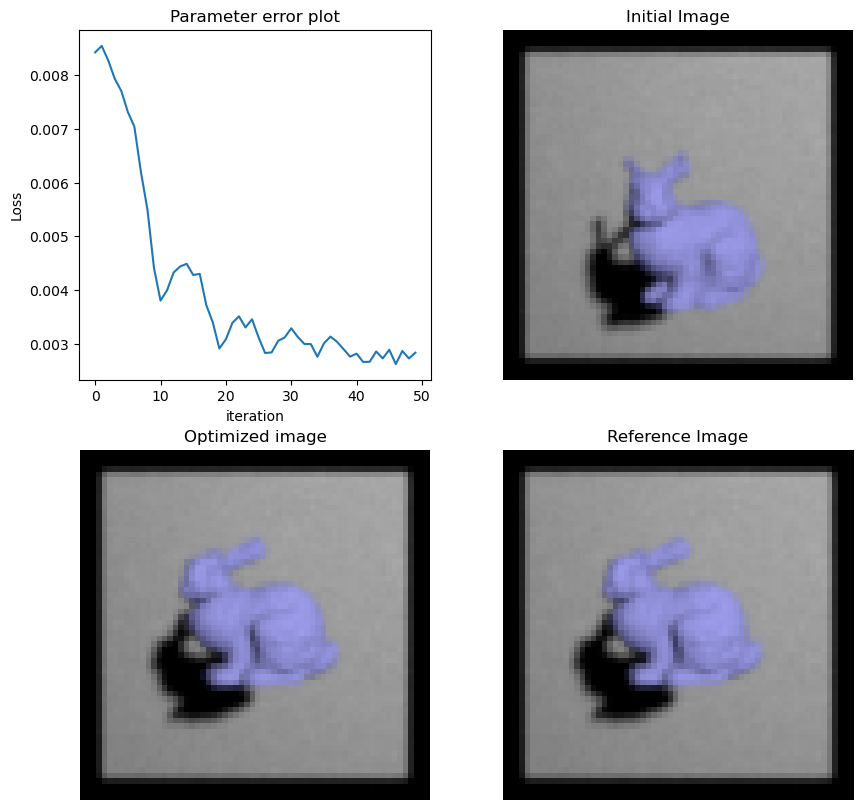

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');